In [1]:
import argparse
import os
import random
import torch
import yaml
from torch.utils.data import DataLoader
from train_model.dataset_utils import prepare_test_data_set, prepare_eval_data_set, prepare_train_data_set
import numpy as np
from os import listdir
from dataset_utils import text_processing
from train_model.helper import run_model, build_model
from IPython.display import Image, display, clear_output
import matplotlib.pyplot as plt
import cv2
import json
from random import shuffle

# Get test images
# wget http://images.cocodataset.org/zips/test2015.zip, unzip and update path to image directory
im_dir = '/private/home/nvivek/vizwiz/Images/'
# Get the models
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/pretrained_models/most_data_models.tar.gz and 
# move the best_model.pth from the uncompressed file to the folder best_model
# Get features
# mkdir data
# cd data
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vqa2.0_glove.6B.300d.txt.npy
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/answers_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/imdb.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/rcnn_10_100.tar.gz
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vocabulary_vqa.txt
# wget https://s3-us-west-1.amazonaws.com/vqa-suite/data/large_vqa2.0_glove.6B.300d.txt.npy
# tar -xf rcnn_10_100.tar.gz
# tar -xf imdb.tar.gz

#/checkpoint/nvivek/test_large_answers_copy_only_ocr/results/baseline_vizwiz_predict/73772
# model_file = '/checkpoint/nvivek/ft_3_class_soft_score_sweep_7k_answer_fasttext/results/baseline_vizwiz_predict/data.batch_size.128_model.ans_loss_weight.0.1_att_loss_weight.0.1_itf_lr.0.005_optimizer.method.Adamax_par.lr.0.005_84615/best_model.pth'


config_file = '/checkpoint/nvivek/test_7k_answers_copy_only_ocr_att/results/baseline_vizwiz_predict/61023/config.yaml'
model_file = '/checkpoint/nvivek/test_7k_answers_copy_only_ocr_att/results/baseline_vizwiz_predict/61023/best_model.pth'
im_feat_dir = '/private/home/nvivek/VQA/training_data/rcnn_adaptive_vizwiz/vizwiz_ocr_text'
test_annot_file = '/private/home/nvivek/vizwiz/Annotations/v2_mscoco_vizwiz_test_annotations.json'
train_annot_file = '/private/home/nvivek/VQA/training_data/v2_mscoco_vizwiz_train_annotations.json'
val_annot_file = '/private/home/nvivek/VQA/training_data/v2_mscoco_vizwiz_val_annotations.json'
max_loc = 137
att_sup_file = 'attention_sup.json'

with open(att_sup_file, 'r') as f:
    att_sups = json.load(f)

def visualize(im_file, im_feature, att_sup=None):
    im = cv2.imread(im_file)
    im_id = int(im_file.split('/')[-1].split('.')[0].split('_')[-1])
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im)

    im_data = np.load(im_feature)
    text = im_data.item().get('image_text').tolist()
    bbox = im_data.item().get('image_bboxes').tolist()
    bbox_source = im_data.item().get('image_bbox_source').tolist()

    if att_sup is None:
        if im_id >= 20000 and im_id < 28000:
            att_sup = [0]*len(bbox_source)
        else:
            att_sup = att_sups[str(im_id)]
    else:
        att_sup = [item for sublist in att_sup for item in sublist]
    
    for i,(source,bbox,text) in enumerate(zip(bbox_source, bbox, text)):
        
        if att_sup[i] >= 0.1:
            text += ' {:.3f}'.format(att_sup[i])
            
        edgecolor = 'red'
        if source[0] == 1:
            edgecolor = 'green'
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False, alpha=0.5,
                          edgecolor=edgecolor, linewidth=3.5)
            )
        box_text = '{:s}'.format(text)
        ax.text(bbox[0] + 5, bbox[1] + 5,
                box_text,
                bbox=dict(alpha=0.5),
                fontsize=14, color='white')
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt_file_path = im_file.split('/')[-1].replace(".jpg", "_pltbb.jpg")
    plt.savefig(plt_file_path)
    clear_output()
    display(Image(filename=plt_file_path))

def visualize_att(im_file, im_feature, att, k, show=False):
    im = cv2.imread(im_file)
    im = im[:, :, (2, 1, 0)]
    if show:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.imshow(im)

    im_data = np.load(im_feature)
    text = im_data.item().get('image_text').tolist()
    bbox = im_data.item().get('image_bboxes').tolist()
    bbox_source = im_data.item().get('image_bbox_source').tolist()

    top_k_idx = list(np.argsort(att)[-k:])
    best_text = ''

    for i,(source,bbox,text) in enumerate(zip(bbox_source, bbox, text)):

        edgecolor = 'red'
        if source[0] == 1:
            edgecolor = 'green'
        fill = False
        alpha = 0.5
        if i not in top_k_idx:
            continue
        if i == top_k_idx[-1]:
            best_text = text
        if not show:
            continue
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=fill, alpha=alpha,
                          edgecolor=edgecolor, linewidth=3.5)
            )
        box_text = '{:s} {:.3f}'.format(text, att[i])
        
        ax.text(bbox[0] + 5, bbox[1] + 5,
                box_text,
                bbox=dict(alpha=0.5),
                fontsize=14, color='white')

    if show:
        plt.axis('off')
        plt.tight_layout()
        plt.draw()
        plt_file_path = im_file.split('/')[-1].replace(".jpg", "_pltatt.jpg")
        plt.savefig(plt_file_path)
        clear_output()
        display(Image(filename=plt_file_path))
    return best_text
    

def get_image(source='test'):
    im_files = [f for f in os.listdir(im_dir) if source in f]
    im_file = random.choice(im_files)
    im_path = os.path.join(im_dir, im_file)
    clear_output()
    print(im_path)
    im_feature_path = os.path.join(im_feat_dir, 'COCO_' + im_file.split('/')[-1].replace(".jpg", ".npy").lower())
    # visualize(im_path, im_feature_path)
    # display(Image(filename=im_path))
    return im_file

def get_imdb(im_file, question_str):
    imdb = []
    imdb.append({'dataset_name': 'vizwiz', 'version': 1, 'has_answer': False, 'has_gt_layout': False})
    iminfo = {}
    iminfo['image_name'] = im_file.replace('.jpg', '')
    iminfo['img_id'] = int(iminfo['image_name'].split('_')[-1])
    iminfo['question_id'] = 0
    iminfo['feature_path'] = 'COCO_' + iminfo['image_name'].lower() + '.npy'
    iminfo['question_str'] = question_str
    iminfo['question_tokens'] = text_processing.tokenize(iminfo['question_str'])
    imdb.append(iminfo)
    return imdb

def print_result(question_ids, soft_max_result, ans_dic):
    predicted_answers = np.argsort(soft_max_result, axis=1)[0][-3:]
    # predicted_answers = np.argmax(soft_max_result, axis=1)
    answers = []
    scores = []
    for idx, pred_idx in enumerate(predicted_answers):
        pred_ans = ans_dic.idx2word(pred_idx)
        answers.append(pred_ans)
        scores.append(soft_max_result[0][pred_idx])
    return answers, scores

with open(config_file, 'r') as f:
    config = yaml.load(f)

with open(test_annot_file, 'r') as f:
    data = json.load(f)
test_annot = data['annotations']

with open(train_annot_file, 'r') as f:
    data = json.load(f)
train_annot = data['annotations']

with open(val_annot_file, 'r') as f:
    data = json.load(f)
val_annot = data['annotations']

data_set_test = prepare_test_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)
data_set_val = prepare_eval_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)
data_set_train = prepare_train_data_set(**config['data'], **config['model'], verbose=True, test_mode=True)

myModel = build_model(config, data_set_test)
state_dict = torch.load(model_file)['state_dict']
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.','')
    new_state_dict[name] = v

myModel.load_state_dict(new_state_dict)

i = 0

results = '/checkpoint/nvivek/test_7k_answers_copy_only_ocr_att/results/baseline_vizwiz_predict/61023/best_model_predict_val.json'
with open(results, 'r') as f:
    predictions = json.load(f)

im_dir = '/private/home/nvivek/vizwiz/Images'

test_questions_file = '/private/home/nvivek/VQA/training_data/v2_OpenEnded_mscoco_vizwiz_test_questions.json'
val_questions_file = '/private/home/nvivek/VQA/training_data/v2_OpenEnded_mscoco_vizwiz_val_questions.json'

with open(test_questions_file, 'r') as f:
    test_questions = json.load(f)

with open(val_questions_file, 'r') as f:
    val_questions = json.load(f)

val_questions = val_questions['questions']
test_questions = test_questions['questions']

def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False

vocabulary_100k.txt
imdb does not contain ground-truth layout
Loading model and config ...
vocabulary_100k.txt
imdb does not contain ground-truth layout
Loading model and config ...
vocabulary_100k.txt
imdb does not contain ground-truth layout
Loading model and config ...
Vocab 75501
Answers 7371
[{'method': 'default_image', 'par': {}}]
Building final model
ModuleList(
  (0): AttQuestionEmbedding(
    (embedding): Embedding(75501, 300)
    (LSTM): LSTM(300, 1024, batch_first=True)
    (Dropout): Dropout(p=0.0)
    (conv1): Conv1d(1024, 512, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(512, 2, kernel_size=(1,), stride=(1,))
  )
)
ModuleList(
  (0): ModuleList(
    (0): image_embedding(
      (image_attention_model): top_down_attention(
        (modal_combine): non_linear_elmt_multiply(
          (Fa_image): nonlinear_layer(
            (main): Sequential(
              (0): Linear(in_features=2048, out_features=5000, bias=True)
              (1): ReLU()
            )
          )
 

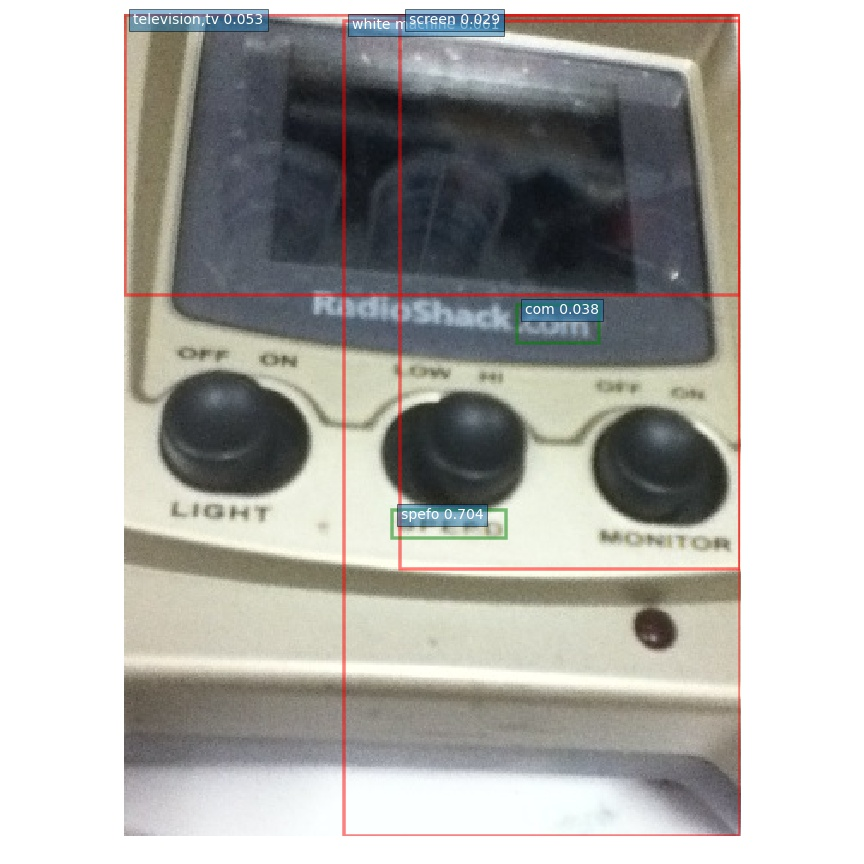

VizWiz_val_000000028527.jpg
What is this?
{'image_name': 'COCO_vizwiz_val_000000028527', 'image_id': 28527, 'question_id': 527, 'feature_path': 'COCO_vizwiz_val_000000028527.npy', 'question_str': 'What is this?', 'question_tokens': ['what', 'is', 'this'], 'all_answers': ['cassette player', 'recorder', 'light device', 'unanswerable', 'unanswerable', 'unsuitable', 'unsuitable', 'electronic device', 'controller', 'control panel'], 'valid_answers': ['cassette player', 'recorder', 'unanswerable', 'unanswerable', 'unsuitable', 'unsuitable', 'electronic device', 'controller', 'control panel'], 'att_sup': array([[0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.16666667],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.16666667],
       [0.16666667],
       [0.        ],
       [0.        ],
       [0.16666667],
       [0.16666667],
       [0.16666667],
       [0.        ],
       [0.        ],
       [0.       

In [ ]:
# Good examples
# VizWiz_train_000000009017.jpg
# VizWiz_train_000000013282.jpg
# VizWiz_train_000000011531.jpg
# VizWiz_train_000000007658.jpg
# VizWiz_train_000000008618.jpg
# VizWiz_train_000000010968.jpg
# VizWiz_train_000000010978.jpg

# VizWiz_test_000000020573.jpg
# VizWiz_test_000000020188.jpg

# Tries to read
# VizWiz_test_000000026706.jpg
# VizWiz_test_000000026163.jpg - answer not in vocab
# VizWiz_test_000000025030.jpg
# VizWiz_test_000000024759.jpg
# VizWiz_test_000000026580.jpg
# VizWiz_test_000000023290.jpg
# VizWiz_test_000000026569.jpg
# VizWiz_test_000000020277.jpg
# VizWiz_test_000000021706.jpg
# VizWiz_test_000000025870.jpg


# More examples
# VizWiz_test_000000025557.jpg decaf
# VizWiz_test_000000023489.jpg garlic
# VizWiz_test_000000027300.jpg hp
# VizWiz_test_000000025822.jpg good - sauvignon
# VizWiz_test_000000022343.jpg good - beans
# VizWiz_test_000000022956.jpg - era laundry
# VizWiz_test_000000022974.jpg - sweet
# VizWiz_test_000000024612.jpg - tea flavors left to right
# VizWiz_test_000000020566.jpg - bacon for cheetos
# VizWiz_test_000000027822.jpg - better to pick unsuitable/unasnwerable

# New model
# read spelling wrong - VizWiz_test_000000024567.jpg
# VizWiz_test_000000021901.jpg
# VizWiz_test_000000021862.jpg
# VizWiz_test_000000024668.jpg
# VizWiz_test_000000020275.jpg
# VizWiz_test_000000027393.jpg - rotated OCR 
# VizWiz_test_000000021960.jpg - Welch

# VizWiz_test_000000020771.jpg - good examples
# VizWiz_test_000000026035.jpg - windex
# VizWiz_test_000000025294.jpg - Joohnston

# VizWiz_test_000000027512.jpg - sasko, brown

examples = ['VizWiz_train_000000009017.jpg', 'VizWiz_train_000000013282.jpg', 'VizWiz_train_000000011531.jpg', 
            'VizWiz_train_000000007658.jpg', 'VizWiz_train_000000008618.jpg', 'VizWiz_train_000000010968.jpg', 
            'VizWiz_train_000000010978.jpg']


val_imdb_file = '/private/home/nvivek/VQA/training_data/imdb/imdb_vizwiz_val_7k_att_ans_ocr_only_copy.npy'
val_imdb = np.load(val_imdb_file)


source = 'test'
train_index = 0
val_index = 28000
test_index = 20000
# im_file = 'VizWiz_train_000000019050.jpg'
# im_file = 'VizWiz_train_000000015775.jpg'
# im_file = 'VizWiz_train_000000019377.jpg'
# im_file = 'VizWiz_test_000000022465.jpg'
# im_file = get_image(source)
# im_file = 'VizWiz_test_000000026163.jpg'
# im_file = examples[i%len(examples)]
# i+=1
# im_file_path = os.path.join(im_dir, im_file)
# im_feature_path = os.path.join(im_feat_dir, 'COCO_' + im_file.split('/')[-1].replace(".jpg", ".npy").lower())

# print(im_file)
# im_id = int(im_file.split('.')[0].split('_')[-1])

# question_str = ''
# gt = '' 
# if source == 'train':
#     question_str = train_annot[im_id - train_index]['question']
#     gt = train_annot[im_id - train_index]['multiple_choice_answer']
# elif source == 'val':
#     question_str = val_annot[im_id - vsl_index]['question']
#     gt = val_annot[im_id - val_index]['multiple_choice_answer']
# elif source == 'test':
#     question_str = test_annot[im_id - test_index]['question']

# data_set_test.datasets[0].imdb = get_imdb(im_file, question_str)
# data_reader_test = DataLoader(data_set_test, shuffle=False, batch_size=1)
ans_dic = data_set_test.answer_dict

# myModel.eval()
# question_ids, soft_max_result, i_att, it_att = run_model(myModel, data_reader_test, ans_dic.UNK_idx)
total = 0
shuffle(predictions)
modified_pred = []
for prediction in predictions:
    # clear_output()
    im_file = prediction['image']
    im_file_path = os.path.join(im_dir, im_file)
    im_feature_path = os.path.join(im_feat_dir, 'COCO_' + im_file.split('/')[-1].replace(".jpg", ".npy").lower())
    im_id = int(im_file.replace('.jpg','').split('_')[-1])
    print(im_id)
    question = val_questions[im_id - val_index]['question']
    answer = prediction['answer']
    gt = val_annot[im_id - val_index]['multiple_choice_answer']
    all_answers = [ans['answer'] for ans in val_annot[im_id - val_index]['answers']]
    data_set_val.datasets[0].imdb = get_imdb(im_file, question)
    data_reader_test = DataLoader(data_set_val, shuffle=False, batch_size=1)
    myModel.eval()
    question_ids, soft_max_result, i_att, it_att = run_model(myModel, data_reader_test, ans_dic.UNK_idx)
    predicted_answers, scores = print_result(question_ids, soft_max_result, ans_dic)
    butd_att = i_att[0].cpu().detach().numpy().reshape((137,)).tolist() 
    text_att = it_att[0].cpu().detach().numpy().reshape((137,)).tolist()
    best_text = visualize_att(im_file_path, im_feature_path, text_att, 5)        
    
    total += 1
    print(total)
    if answer == '<copy>':
        visualize(im_file_path, im_feature_path, val_imdb[im_id - val_index + 1]['att_sup'].tolist())
        command = input()
        visualize_att(im_file_path, im_feature_path, text_att, 5, show=True)
        print(im_file)
        print(question)
        print(val_imdb[im_id - val_index + 1])
        print("Groundtruth: " + gt)
        print(all_answers)
        print("Answer: " + predicted_answers[-1])
        print("Image text " + best_text)
        print("Top answers " + str(predicted_answers))
        print("Scores " + str(scores))
#         new_prediction = {}
#         new_prediction['image'] = im_file
#         try:
#             best_text.encode('ascii')
#             new_prediction['answer'] = best_text
#         except:
#             new_prediction['answer'] = predicted_answers[-2]
#         if new_prediction['answer'] == '':
#             new_prediction['answer'] = predicted_answers[-2]
#         modified_pred.append(new_prediction)
#         print(sorted(text_att))
#         print(sorted(butd_att))
        command = input()
        if command == 'bye':
            break
        else:
            continue
    else:
        modified_pred.append(prediction)

        
# with open('copy_model_predict_test.json', 'w') as f:
#     json.dumps(modified_pred)
# visualize(im_file_path, im_feature_path)
# print(question_str)
# print("Groundtruth: " + gt)
# print("Answer: ")
# print_result(question_ids, soft_max_result, ans_dic)

# visualize_att(im_file_path, im_feature_path, butd_att,5)
# visualize_att(im_file_path, im_feature_path, text_att,5)
# print(sum(butd_att))
# print(sum(text_att))
# print(sorted(butd_att))
# print(sorted(text_att))
# print(len([x for x in butd_att if x > 0]))
# print(len([x for x in text_att if x > 0]))

In [ ]:
print(len(modified_pred))
print(modified_pred[0])

In [ ]:
# with open('copy_model_predict_test_copy_only_ocr.json', 'r') as f:
#     data1 = json.load(f)
# with open('best_single_model.json', 'r') as f:
#     data2 = json.load(f)

In [ ]:
# print(len(data1))
# print(len(data2))

In [ ]:
# data1_dict = {}
# data2_dict = {}
# for item in data1:
#     data1_dict[item['image']] = item['answer']
# for item in data2:
#     data2_dict[item['image']] = item['answer']
# print(len(data1_dict))
# print(len(data2_dict))

# test_questions_file = '/private/home/nvivek/VQA/training_data/v2_OpenEnded_mscoco_vizwiz_test_questions.json'
# with open(test_questions_file, 'r') as f:
#     test_questions = json.load(f)
# test_questions = test_questions['questions']  
# test_index = 20000
# for item in data1_dict.keys():
#     data1_ans = data1_dict[item]
#     data2_ans = data2_dict[item]
#     if data1_ans != data2_ans:
#         print(item)
#         im_id = int(item.replace('.jpg','').split('_')[-1])
#         question = test_questions[im_id - test_index]['question']
#         clear_output()
#         display(Image(filename=os.path.join(im_dir, item)))
#         print(im_id)
#         print(question)
#         print(data1_ans)
#         print(data2_ans)
#         command = input()

In [ ]:
val_imdb_file = '/private/home/nvivek/VQA/training_data/imdb/imdb_vizwiz_val_large_ocr_only_att_uns_una_sup_copy.npy'
val_imdb = np.load(val_imdb_file)
att_sup = val_imdb[308]['att_sup'].tolist()
flat_list = [item for sublist in att_sup for item in sublist]
print(len(flat_list))